In [1]:
from collections import Counter
import itertools
import logging

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from unseal.hooks import Hook, HookedModel
from unseal.hooks.common_hooks import save_output

from circuits_util import get_o_weight, get_qkv_weights
from datasets import get_dataset
from model import GrokkingTransformer
from utils import load_model

device = 'cuda' if torch.cuda.is_available() else 'cpu'

if device == 'cpu':
    logging.warning('No GPU found! Using CPU')

In [2]:
model_name = 'Single Layer ReLU'
ckpt, ckpt_dir = load_model(model_name)

model = GrokkingTransformer.load_from_checkpoint(ckpt).to(device)
model.eval()

key_layer = model.transformer[0].linear_net[0].weight
value_layer = model.transformer[0].linear_net[-1].weight

In [3]:
values = {219: value_layer[:, 219], 268: value_layer[:, 268], 446: value_layer[:, 446]}

for key1, key2 in itertools.combinations(values.keys(), r=2):
    print(f'angle({key1},{key2}) = {180/torch.pi * torch.arccos((values[key1] * values[key2]).sum() / values[key1].pow(2).sum().sqrt() / values[key2].pow(2).sum().sqrt()):.3f} deg')

angle(219,268) = 44.266 deg
angle(219,446) = 33.445 deg
angle(268,446) = 72.878 deg


In [4]:
# What's the distribution over key magnitudes for these three value vectors, over the whole dataset?
# Which inputs activate them the most?
dataset = torch.from_numpy(get_dataset(descr='minus', num_elements=97, data_dir='./data').data).to(device)

In [50]:
hooked_model = HookedModel(model)
save_key_mag_hook = Hook("transformer->0->linear_net->2", save_output(), key="save_key_magnitude")
save_pre_key_hook = Hook("transformer->0->norm1", save_output(), key="save_pre_key")
save_embedded_hook = Hook("pos_encoding", save_output(), key="save_embedded")
save_attn_out_hook = Hook("transformer->0->self_attn", save_output(), key="save_attn_out")
hooked_model(dataset[:,:-1], hooks=[save_key_mag_hook, save_pre_key_hook, save_embedded_hook, save_attn_out_hook])
print('')

In [6]:
key_magnitude = hooked_model.save_ctx['save_key_magnitude']['output'][:,-1,[219,268,446]]
print(key_magnitude.shape)

torch.Size([9409, 3])


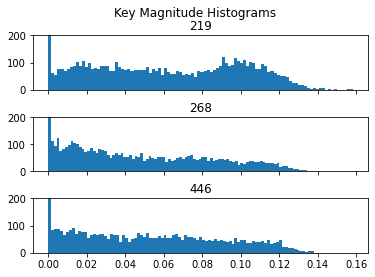

In [7]:
fig, axes = plt.subplots(3, 1, sharex=True, sharey=True, gridspec_kw={'hspace': 0.5})
for i in range(3):
    axes[i].hist(key_magnitude[:,i].detach().numpy(), bins=100)
    axes[i].set_title(f"{[219,268,446][i]}")
# plt.xlim(0.000, 0.041)
plt.ylim(0,200)
plt.suptitle(f"Key Magnitude Histograms")
plt.show()

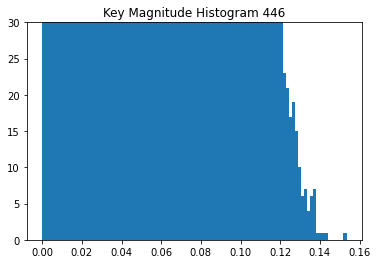

In [8]:
# look at the histogram for 446 individually
plt.figure()
plt.hist(key_magnitude[:,2].detach().numpy(), bins=100)
plt.ylim(0,30)
plt.title('Key Magnitude Histogram 446')
plt.show()

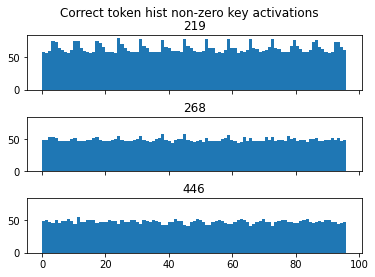

In [9]:
# get the data points to the largest 100 magnitudes


fig, axes = plt.subplots(3, 1, sharex=True, sharey=True, gridspec_kw={'hspace': 0.5})
for i, key in enumerate([219,268,446]):
    axes[i].hist(dataset[key_magnitude[:,i] != 0][:,-1].cpu().numpy(), bins=97)
    axes[i].set_title(f"{key}")
plt.suptitle('Correct token hist non-zero key activations')
plt.show()

In [10]:
first_counts = list(Counter(dataset[key_magnitude[:,2] != 0][:,0].cpu().numpy()).items())
last_counts = list(Counter(dataset[key_magnitude[:,2] != 0][:,-1].cpu().numpy()).items())
second_counts = list(Counter(dataset[key_magnitude[:,2] != 0][:,2].cpu().numpy()).items())

first_counts = sorted(first_counts, key=lambda x: x[1], reverse=True)
second_counts = sorted(second_counts, key=lambda x: x[1], reverse=True)
last_counts = sorted(last_counts, key=lambda x: x[1], reverse=True)

print(f'First   Count')
for tup in first_counts[:10]:
    print(f'{tup[0]:6d} {tup[1]:6d}')

print(f'Second   Count')
for tup in second_counts[:10]:
    print(f'{tup[0]:6d} {tup[1]:6d}')

print(f'Last   Count')
for tup in last_counts[:10]:
    print(f'{tup[0]:6d} {tup[1]:6d}')


First   Count
    62     96
    41     95
    82     95
    83     95
    13     94
    69     94
    90     94
     7     91
    48     90
    55     90
Second   Count
    69     85
    89     84
    13     81
    61     80
    27     79
    54     78
    82     78
     6     75
    41     75
    48     75
Last   Count
    11     55
    42     53
    84     52
    70     52
    63     52
    49     52
     8     52
    91     51
    83     51
    50     51


In [11]:
first_counts = list(Counter(dataset[key_magnitude[:,0] != 0][:,0].cpu().numpy()).items())
last_counts = list(Counter(dataset[key_magnitude[:,0] != 0][:,-1].cpu().numpy()).items())
second_counts = list(Counter(dataset[key_magnitude[:,0] != 0][:,2].cpu().numpy()).items())

first_counts = sorted(first_counts, key=lambda x: (x[1], key_magnitude[(key_magnitude[:,0] != 0) & (dataset[:,0]==x[0]).cpu()].mean()), reverse=True)
second_counts = sorted(second_counts, key=lambda x: x[1], reverse=True)
last_counts = sorted(last_counts, key=lambda x: x[1], reverse=True)

print(f'First   Count')
for i, tup in enumerate(first_counts):
    print(f'{tup[0]:6d} {tup[1]:6d} {key_magnitude[(key_magnitude[:,0] != 0) & (dataset[:,0]==tup[0]).cpu()].mean():.3f}')

print(f'Second   Count')
for tup in second_counts[:10]:
    print(f'{tup[0]:6d} {tup[1]:6d}')

print(f'Last   Count')
for tup in last_counts[:10]:
    print(f'{tup[0]:6d} {tup[1]:6d}')


First   Count
     7     97 0.076
    90     97 0.075
    28     97 0.072
    69     97 0.070
     0     97 0.070
    83     97 0.069
    14     97 0.069
    21     97 0.066
    35     97 0.066
    62     97 0.064
    56     97 0.063
    55     97 0.062
    48     97 0.062
    41     97 0.062
    76     97 0.061
    22     97 0.060
     8     97 0.060
    43     97 0.060
    63     97 0.059
    91     97 0.059
    15     97 0.058
    42     97 0.058
    49     97 0.058
    77     97 0.055
    20     97 0.055
    84     97 0.054
    70     97 0.054
    82     97 0.053
    34     97 0.053
     6     97 0.052
    13     97 0.052
    36     97 0.052
    71     97 0.052
     1     97 0.050
    89     97 0.048
    96     97 0.048
    64     97 0.047
    75     97 0.044
    61     97 0.041
    54     97 0.040
    33     97 0.040
    50     96 0.047
    57     96 0.047
    29     96 0.046
    68     96 0.041
    27     94 0.048
    40     92 0.035
    47     86 0.037
    26     74 0.032
    19

In [12]:
first_counts = list(Counter(dataset[key_magnitude[:,1] != 0][:,0].cpu().numpy()).items())
last_counts = list(Counter(dataset[key_magnitude[:,1] != 0][:,-1].cpu().numpy()).items())
second_counts = list(Counter(dataset[key_magnitude[:,1] != 0][:,2].cpu().numpy()).items())

first_counts = sorted(first_counts, key=lambda x: x[1], reverse=True)
second_counts = sorted(second_counts, key=lambda x: x[1], reverse=True)
last_counts = sorted(last_counts, key=lambda x: x[1], reverse=True)

print(f'First   Count')
for tup in first_counts[:50]:
    print(f'{tup[0]:6d} {tup[1]:6d}')

print(f'Second   Count')
for tup in second_counts[:10]:
    print(f'{tup[0]:6d} {tup[1]:6d}')

print(f'Last   Count')
for tup in last_counts[:10]:
    print(f'{tup[0]:6d} {tup[1]:6d}')


First   Count
     0     97
     7     97
     8     97
    14     97
    15     97
    22     97
    28     97
    35     97
    43     97
    50     97
    56     97
    64     97
    71     97
    84     97
    90     97
    29     95
    36     95
    91     95
    21     94
    49     92
    70     91
    77     91
    63     90
    42     85
     1     84
    57     83
    69     79
    83     74
    62     70
    76     70
    48     66
    55     66
    78     63
    92     63
    85     61
    34     60
    41     60
    16     57
     2     56
     9     54
    23     53
    27     53
     6     52
    13     52
    89     52
    20     48
    82     47
    30     46
    51     45
    96     45
Second   Count
    22     96
    15     94
    78     92
    50     91
    43     90
    71     87
     8     86
    57     86
    64     86
    36     81
Last   Count
    38     58
    45     57
    59     56
    24     55
    78     54
    31     54
    73     53
    71     53
    64

In [13]:
# value_logits = {key: model.output(values[key]) for key in values.keys()}
value_logits = {key: model.output(model.transformer[0].norm2.weight * values[key]) for key in values.keys()}
print(value_logits[446].shape)

torch.Size([99])


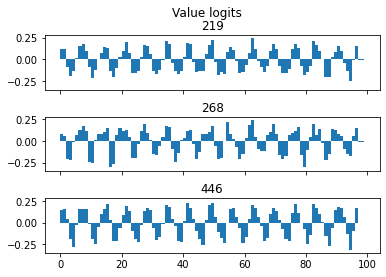

In [14]:
fig, ax = plt.subplots(3,1,sharex=True, sharey=True, gridspec_kw={'hspace': 0.5})
for i, key in enumerate([219,268,446]):
    ax[i].bar(np.arange(len(value_logits[key])), value_logits[key].detach().cpu().numpy(), width=1, align='edge')
    ax[i].set_title(f"{key}")
plt.suptitle('Value logits')
plt.show()

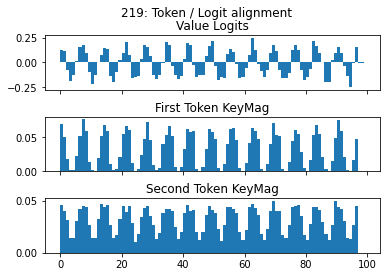

In [15]:
fig, ax = plt.subplots(3,1,sharex=True, gridspec_kw={'hspace': 0.5})
ax[0].bar(np.arange(len(value_logits[219])), value_logits[219].detach().cpu().numpy(), width=1, align='edge')
ax[0].set_title(f"Value Logits")
ax[1].set_title(f"First Token KeyMag")
keymag1 = []
for i in range(97):
    keymag1.append(key_magnitude[(dataset[:,0]==i).cpu()].mean().detach().numpy())
ax[1].bar(np.arange(len(keymag1)), keymag1, width=1, align='edge')

ax[2].set_title(f"Second Token KeyMag")
keymag2 = []
for i in range(97):
    keymag2.append(key_magnitude[(dataset[:,2]==i).cpu()].mean().detach().numpy())
ax[2].bar(np.arange(len(keymag2)), keymag2, width=1, align='edge')


plt.suptitle('219: Token / Logit alignment')
plt.show()

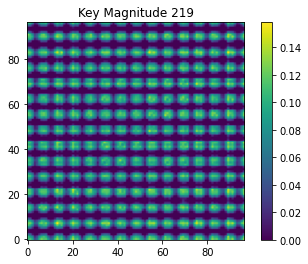

In [16]:
plt.figure()
plt.imshow(key_magnitude[:,0].reshape(97,97).detach().cpu().numpy(), origin='lower', cmap='viridis')
plt.colorbar()
plt.title('Key Magnitude 219')
plt.show()

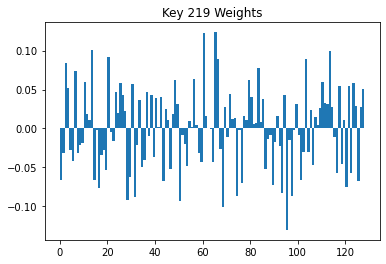

In [17]:
plt.figure()
plt.bar(np.arange(128), key_layer[219,:].detach().cpu().numpy(), width=1, align='edge')
plt.title('Key 219 Weights')
plt.show()

tensor([ 0, 97,  0, 98,  0], device='cuda:0')
tensor([ 5, 97, 11, 98, 91], device='cuda:0')
(2, 128)


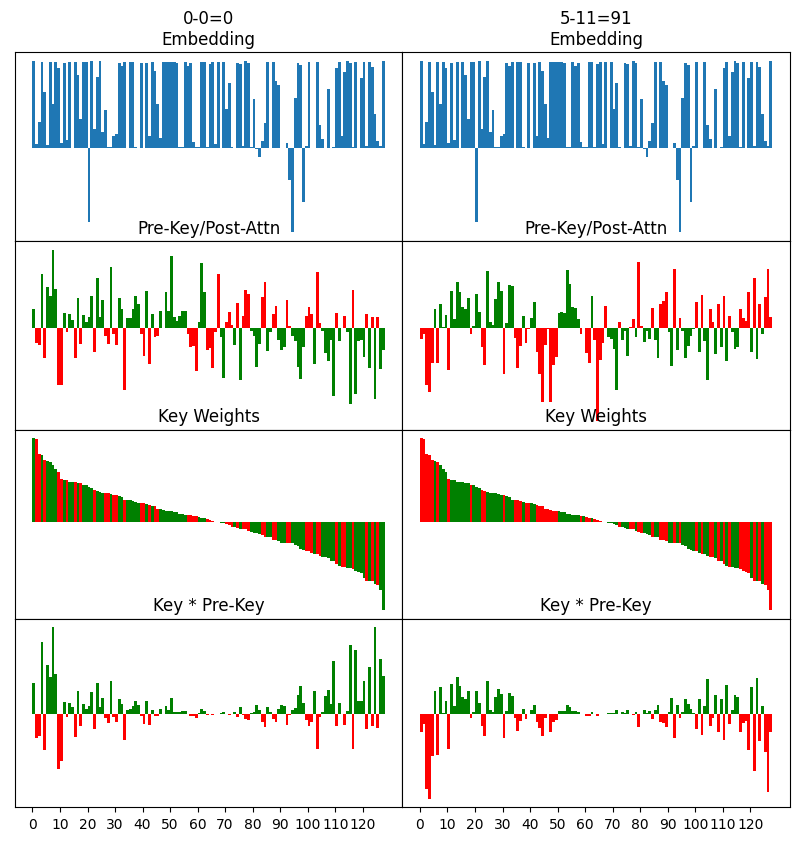

In [18]:
pre_key = hooked_model.save_ctx['save_pre_key']['output'][:,-1].detach().cpu().numpy()

idx1 = 0
idx2 = 5*98 + 6
print(dataset[idx1])
print(dataset[idx2])


embedded = hooked_model.save_ctx['save_embedded']['output'][[idx1,idx2],-1].numpy()
pre_key = hooked_model.save_ctx['save_pre_key']['output'][[idx1,idx2],-1].numpy()
key_matrix = key_layer[219,:].detach().cpu().numpy()
key_pre_key_sign_agreement = np.sign(key_matrix[None] * pre_key)
print(key_pre_key_sign_agreement.shape)
pre_sum = key_matrix[None] * pre_key
colors = np.array([list(map(lambda x: 'green' if x == 1 else 'red', key_pre_key_sign_agreement[i])) for i in range(2)])
sort_idcs = key_matrix.argsort()[::-1]
fig, ax = plt.subplots(4, 2,sharex=True, gridspec_kw={'hspace': 0., 'wspace': 0.}, figsize=(10,10), dpi=100)
for i in range(4):
    for j in range(2):
        if i > 0:
            ax[i,j].bar(np.arange(128), [embedded, pre_key, [key_matrix,key_matrix], pre_sum][i][j][sort_idcs], color=colors[j][sort_idcs], width=1, align='edge')
            ax[i,j].set_title(['Pre-Key/Post-Attn', 'Key Weights', 'Key * Pre-Key'][i-1])
        else:
            ax[i,j].bar(np.arange(128), [embedded, pre_key, [key_matrix,key_matrix], pre_sum][i][j][sort_idcs], width=1, align='edge')
            ax[i,j].set_title(['0-0=0\nEmbedding', '5-11=91\nEmbedding'][j])
        # remove ticks
        if j == 1:
            ax[i,j].sharey(ax[i,0])
        
        if i < 3:
            ax[i,j].set_xticks([])
        
        else:
            ax[i,j].set_xticks(np.arange(0,128,10))
        ax[i,j].set_yticks([])
plt.show()

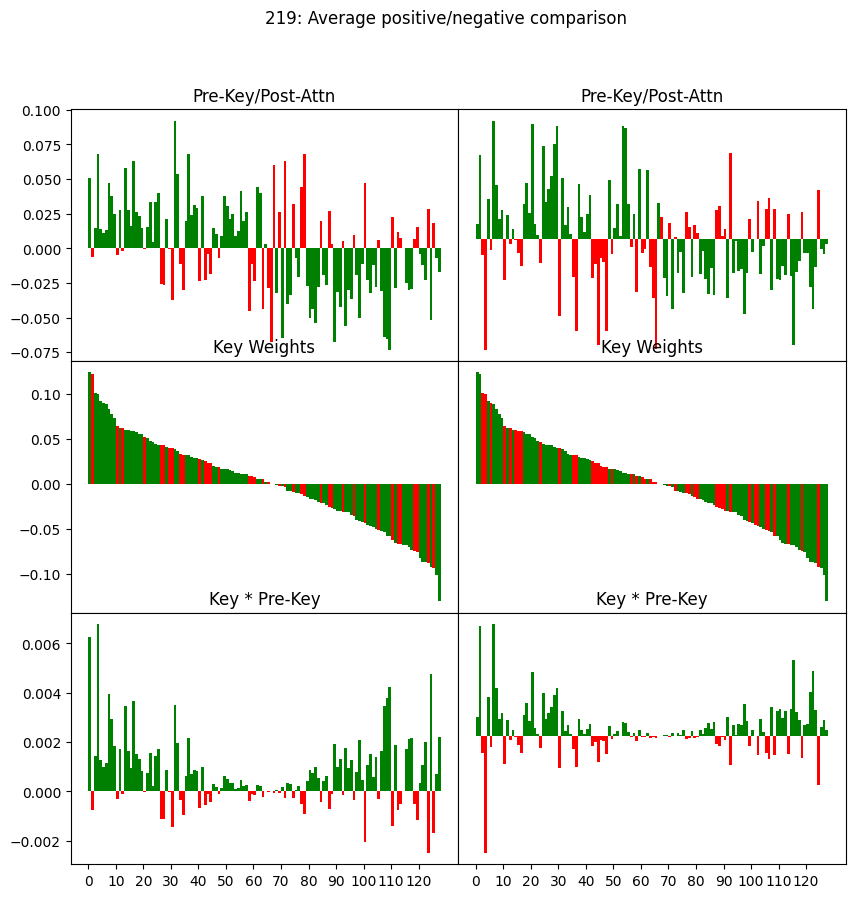

In [31]:
# average of the last row over positive examples
pre_key = hooked_model.save_ctx['save_pre_key']['output'][:,-1].detach().cpu().numpy()

pos_idcs = [(m*7+n*7*97) % 9409 for m, n in itertools.product(range(13), repeat=2)]
neg_idcs = [(5+5*97+m*7+n*7*97) % 9409 for m, n in itertools.product(range(13), repeat=2)]

pos_pre_key = hooked_model.save_ctx['save_pre_key']['output'][pos_idcs,-1].numpy().mean(axis=0)
neg_pre_key = hooked_model.save_ctx['save_pre_key']['output'][neg_idcs,-1].numpy().mean(axis=0)
key_matrix = key_layer[219,:].detach().cpu().numpy()
pos_key_pre_key_sign_agreement = np.sign(key_matrix * pos_pre_key)
neg_key_pre_key_sign_agreement = np.sign(key_matrix * neg_pre_key)
pos_pre_sum = key_matrix * pos_pre_key
neg_pre_sum = key_matrix * neg_pre_key
colors = [np.array(list(map(lambda x: 'green' if x == 1 else 'red', pos_key_pre_key_sign_agreement))), np.array(list(map(lambda x: 'green' if x == 1 else 'red', neg_key_pre_key_sign_agreement)))]
sort_idcs = key_matrix.argsort()[::-1]
fig, ax = plt.subplots(3, 2,sharex=True, gridspec_kw={'hspace': 0., 'wspace': 0.}, figsize=(10,10), dpi=100)
for i in range(3):
    for j in range(2):
        ax[i,j].bar(np.arange(128), [[pos_pre_key, neg_pre_key], [key_matrix, key_matrix], [pos_pre_sum, neg_pre_sum]][i][j][sort_idcs], color=colors[j][sort_idcs], width=1, align='edge')
        ax[i,j].set_title(['Pre-Key/Post-Attn', 'Key Weights', 'Key * Pre-Key'][i])
    
    # remove ticks
    if i < 2:
        ax[i,j].set_xticks([])
        
    else:
        ax[i,j].set_xticks(np.arange(0,128,10))
    ax[i,j].set_yticks([])
plt.suptitle('219: Average positive/negative comparison')
plt.show()

In [81]:
largest_dims = sort_idcs[:10]
smallest_dims = sort_idcs[-10:]
print(largest_dims)
print(smallest_dims)

pos_dims = [largest_dims[0]] + [largest_dims[2]]
neg_dims = [sort_idcs[3]] + [sort_idcs[-4]]
print(pos_dims)
print(neg_dims)

[ 65  60  13 113  20  66 103   2  83   6]
[120  16  93  74  97  31  28  50  68  95]
[65, 13]
[113, 28]


In [35]:
o = get_o_weight(model.transformer[0].self_attn)
q, k, v = get_qkv_weights(model.transformer[0].self_attn)
ov = torch.einsum('bij,bik->bjk', o, v).detach().cpu().numpy()
print(f"{ov.shape = }")

ov.shape = (4, 128, 128)


In [85]:
largest_ov = ov[:,largest_dims]
smallest_ov = ov[:,smallest_dims]
pos_ov = ov[:,pos_dims]
neg_ov = ov[:,neg_dims]

# shape = (batch_size, num_heads, seq_len)
attn = hooked_model.save_ctx['save_attn_out']['output'][1][:,:,-1] # attn that equal sign pays to other tokens

# shape = (batch_size, seq_len, embedding_dim)
pre_attn = hooked_model.save_ctx['save_embedded']['output']

# shape = (batch_size, num_heads, seq_len, embedding_dim)
attn_weighted = pre_attn[:,None] * attn[...,None]  

# mean value that is written to dimensions 65 and 13 by each head, unweighted by attention, so maybe I should weight this with attention!!
# shape = [batch, heads, seq_len, pos_dims]
print('pos')
print(np.einsum('aij,bakj->baki', pos_ov, attn_weighted[pos_idcs].detach().numpy()).sum(axis=2).mean(axis=0))

print('\nneg')
print(np.einsum('aij,bakj->baki', neg_ov, attn_weighted[neg_idcs].detach().numpy()).sum(axis=2).mean(axis=0))

(4, 2, 128)
pos
[[ 0.06660044  0.12489312]
 [-0.08773495  0.044724  ]
 [ 0.04904833  0.24095072]
 [-0.07665625 -0.01196269]]

neg
[[ 1.2598342e-01 -9.9668454e-05]
 [ 3.9277192e-02  4.5879792e-02]
 [-5.1182613e-02 -1.2289899e-02]
 [-4.2385560e-02  2.0592513e-02]]


In [ ]:
print(largest_ov[0].shape)
print(hooked_model.save_ctx['save_embedded']['output'][idx1,0].shape)
for i in range(4):
    print(f'{i}')
    print(largest_ov[i] @ hooked_model.save_ctx['save_embedded']['output'][idx2,0].numpy() - largest_ov[i] @ hooked_model.save_ctx['save_embedded']['output'][idx1,0].numpy())
    print(smallest_ov[i] @ hooked_model.save_ctx['save_embedded']['output'][idx2,0].numpy() - smallest_ov[i] @ hooked_model.save_ctx['save_embedded']['output'][idx1,0].numpy())

(10, 128)
torch.Size([128])
0
[ 0.00202143 -0.00475811  0.00436257  0.00536568  0.00456925 -0.00191821
  0.00093906 -0.00031796  0.00100015  0.00137969]
[ 0.00484711 -0.01436272 -0.00205071 -0.00302378 -0.00154266 -0.00280691
 -0.00063169  0.00327183  0.00119988  0.00199905]
1
[-6.7938790e-03 -1.8224679e-03  1.6922802e-03 -3.9839000e-03
  1.5310720e-03 -7.5707026e-04  1.5332699e-03 -8.6016953e-05
  6.8028644e-04  6.4448453e-04]
[-3.8863719e-04 -6.8571381e-03  1.7156154e-03  1.0941386e-02
 -1.4673322e-03  6.2420964e-05 -2.6690327e-03 -2.8658584e-03
  7.4136257e-04  1.0373488e-02]
2
[-6.8308040e-04  2.0712614e-06  9.7785741e-03  5.5238940e-03
 -9.1025978e-04 -1.6798936e-03  3.0567888e-03 -1.4346391e-03
  2.0181313e-03  1.9456632e-03]
[-0.00469723 -0.00523578 -0.00609377 -0.00042198 -0.00203359  0.0019798
 -0.00355014  0.00647003  0.00156171  0.00311098]
3
[ 4.0134452e-03 -6.3569471e-04 -2.3123678e-03  2.9429793e-05
  4.2558461e-03 -2.2762083e-04 -2.8342009e-05 -4.6169385e-04
  1.2129992e